In [1]:
from dataclasses import dataclass
import pandas as pd
import os
import SimpleITK as sitk

import keras as tfk
from keras import layers as tfkl

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.data import Dataset as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

sns.set_theme()

In [2]:
SEED = 42
BATCH_SIZE = 64
IMG_HEIGHT = 512
IMG_WIDTH = 512
SHUFFLE_BUFFER_SIZE = 100
METRICS = ["accuracy", "recall", "f1_score"]

data_dir = '/kaggle/input/lung-ds-balanced/Full_slice'

tfk.utils.set_random_seed(SEED)

In [3]:
import os
import shutil

# Define writable working directory
working_dir = "/kaggle/working/Full_slice_copy"

# Copy the dataset to the working directory (if not already copied)
if not os.path.exists(working_dir):
    shutil.copytree(data_dir, working_dir)
    print("Dataset copied to writable directory.")

# Loop over both "train" and "val" folders
for folder in ["train", "val"]:
    folder_path = os.path.join(working_dir, folder)
    
    # Keep only 887 files in 0
    if folder == 'train':
        subfolder_path = os.path.join(folder_path, "0")
        if os.path.exists(subfolder_path):
            files = sorted(os.listdir(subfolder_path), reverse=True)  # Sort files in reverse order
            files_to_delete = files[887:]  # Select files beyond the last 887
        
            for file in files_to_delete:
                file_path = os.path.join(subfolder_path, file)
                os.remove(file_path)  # Delete the file

    # Move files from 1 and 2 → 0
    for subfolder in ["1", "2"]:
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.exists(subfolder_path):
            if folder == 'train':
                files = sorted(os.listdir(subfolder_path), reverse=True)  # Sort files in reverse order
                files_to_move = files[:887]  # Select the last 887 files
            else:
                files_to_move = os.listdir(subfolder_path)
            
            for file in files_to_move:
                filename, ext = os.path.splitext(file)
                new_filename = f"{filename}_{subfolder}{ext}"
                shutil.move(
                    os.path.join(subfolder_path, file),
                    os.path.join(folder_path, "0", new_filename)
                )
                
            # Delete remaining files in subfolder "1" that were not moved
            if subfolder == "1" and folder == "train":
                remaining_files = os.listdir(subfolder_path)
                for file in remaining_files:
                    os.remove(os.path.join(subfolder_path, file))

    # Move files from 3 and 4 → 1
    for subfolder in ["3", "4"]:
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.exists(subfolder_path):
            for file in os.listdir(subfolder_path):
                filename, ext = os.path.splitext(file)
                new_filename = f"{filename}_{subfolder}{ext}"
                shutil.move(
                    os.path.join(subfolder_path, file),
                    os.path.join(folder_path, "1", new_filename)
                )

    # Delete folders 2, 3, and 4
    for subfolder in ["2", "3", "4"]:
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.exists(subfolder_path):
            shutil.rmtree(subfolder_path)

print("Files moved and folders deleted successfully!")

Dataset copied to writable directory.
Files moved and folders deleted successfully!


In [4]:
import os

base_path = "/kaggle/working/Full_slice_copy"

# Loop over "train" and "val"
for folder in ["train", "val"]:
    folder_path = os.path.join(base_path, folder)
    print(f"\nFolder: {folder}")

    # Count files in each remaining subfolder (0 and 1)
    for subfolder in ["0", "1"]:
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.exists(subfolder_path):
            num_files = len(os.listdir(subfolder_path))
            print(f"  {subfolder}: {num_files} images")
        else:
            print(f"  {subfolder}: Does not exist")



Folder: train
  0: 2661 images
  1: 2660 images

Folder: val
  0: 351 images
  1: 122 images


In [5]:
train_datagen = ImageDataGenerator(
    rotation_range=30,            
    # width_shift_range=0.2,        
    # height_shift_range=0.2,       
    shear_range=0.2,              
    zoom_range=0.2,               
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0    
)

val_datagen = ImageDataGenerator(

)

train_generator = train_datagen.flow_from_directory(
    working_dir + "/train",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
    #subset='training'               
)

val_generator = val_datagen.flow_from_directory(
    working_dir + "/val",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
    #subset='val'
)

Found 5321 images belonging to 2 classes.
Found 473 images belonging to 2 classes.


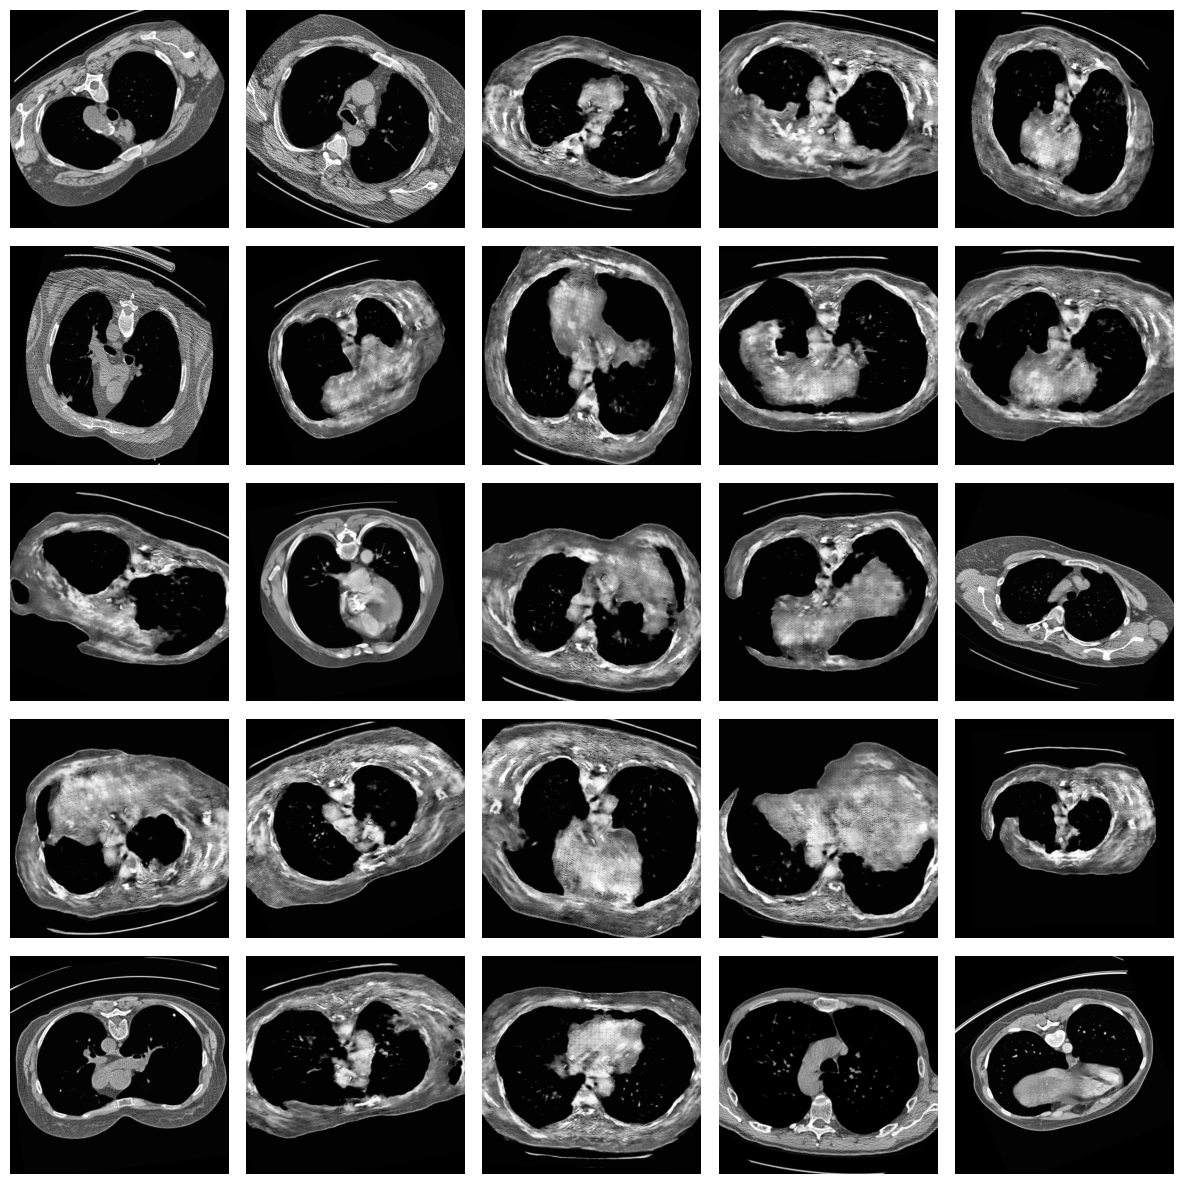

In [6]:
# Get one batch of augmented images
augmented_images, _ = next(train_generator)  # Ignore labels (_)

# Plot a 5x5 grid of augmented images
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
axes = axes.flatten()

for img, ax in zip(augmented_images[:25], axes):  # Take the first 25 images
    ax.imshow(img[:, :, 0], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
@dataclass
class Hyperparameters:
    # Model
    activation = "relu"
    # Training
    # noise_std: float = 0.05 # then try 0.1
    optimiser = tfk.optimizers.Adam
    learning_rate = 1e-4
    weight_decay = 1e-4
    regularization1 = tfk.regularizers.L1L2(l1=1e-5, l2=0)
    regularization2 = tfk.regularizers.L1L2(l1=0, l2=0)
    loss = tfk.losses.BinaryCrossentropy(from_logits=False)
    epochs = 50
    ## Early stopping parameters
    es_patience = 10
    es_min_delta = 1e-2
    ## Learning rate schedule
    lr_patience = 5
    lr_decay_factor = 0.3
    lr_min_delta = 5e-2 
    min_lr = 1e-6

hp = Hyperparameters()

In [8]:
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np

# # Get unique class labels
# classes = np.array([0, 1])

# # Compute class weights automatically
# class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_generator.classes)

# # Convert to dictionary
# class_weights = dict(zip(classes, class_weights))

# print(class_weights)

In [9]:
def build_model(hp: Hyperparameters,
                feature_extractor: tfk.applications):
    
    inputs = tfkl.Input((IMG_HEIGHT, IMG_WIDTH, 3))

    # x = tfkl.Rescaling(1./255)(inputs)
    # gn = tfkl.GaussianNoise(hp.noise_std)(x)
    # x = tfkl.Rescaling(255)(gn)

    backbone_output = feature_extractor(inputs)

    conv_layer = tfkl.Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same')(backbone_output) 
    max_pool_layer = tfkl.MaxPooling2D(pool_size=(2, 2))(conv_layer)
    flatten_layer = tfkl.Flatten()(max_pool_layer) 

    x = tfkl.Dropout(0.6)(flatten_layer)

    x = tfkl.Dense(1024, activation='relu')(x)
    x = tfkl.Dense(512, activation='relu')(x)
    x = tfkl.Dense(256, activation='relu')(x)
    #x = tfkl.Dense(128, activation='relu')(x)

    x = tfkl.Dropout(0.4)(x)

    output = tfkl.Dense(1, activation="sigmoid")(x)
    
    model = tfk.Model(inputs, output)
    return model

In [10]:
def fit(model: tfk.Model,
        train_generator: ImageDataGenerator,
        val_generator: ImageDataGenerator,
        hp: Hyperparameters):
    model.compile(loss=hp.loss,
                  optimizer=hp.optimiser(learning_rate=hp.learning_rate, weight_decay=hp.weight_decay), 
                  metrics=['accuracy'])
    
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=hp.epochs,
        # class_weight=class_weights,
        #validation_data=val_dataset,
        callbacks=[
            tfk.callbacks.EarlyStopping(monitor='val_loss', 
                                        #mode='min',
                                        patience=hp.es_patience, 
                                        restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(
                factor=hp.lr_decay_factor,
                patience=hp.lr_patience,
                min_delta=hp.lr_min_delta,
                min_lr=hp.min_lr,
                verbose=1,
            )
    ]
    
    ).history

    return model, history

In [11]:
backbone = tfk.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(512,512,3),
    pooling=None #'avg'
)

backbone.trainable = False

model = build_model(hp, backbone)

model, history = fit(model, train_generator, val_generator, hp)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


84/84 ━━━━━━━━━━━━━━━━━━━━ 342s 3s/step - accuracy: 0.5725 - loss: 1.1211 - val_accuracy: 0.7421 - val_loss: 0.5920 - learning_rate: 1.0000e-04
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 278s 3s/step - accuracy: 0.6689 - loss: 0.6214 - val_accuracy: 0.7421 - val_loss: 0.5804 - learning_rate: 1.0000e-04
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 275s 3s/step - accuracy: 0.6709 - loss: 0.6216 - val_accuracy: 0.7378 - val_loss: 0.5665 - learning_rate: 1.0000e-04
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 275s 3s/step - accuracy: 0.6785 - loss: 0.6116 - val_accuracy: 0.7421 - val_loss: 0.5789 - learning_rate: 1.0000e-04
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 281s 3s/step - accuracy: 0.6810 - loss: 0.6121 - val_accuracy: 0.7400 - val_loss: 0.5650 - learning_rate: 1.0000e-04
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6823 - loss: 0.6044
Epoch 6: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
84/84 ━━━━━━━━━━━━━━━━━━━━ 283s 3s/step - accuracy: 0.6823 - loss: 0.6044 - 

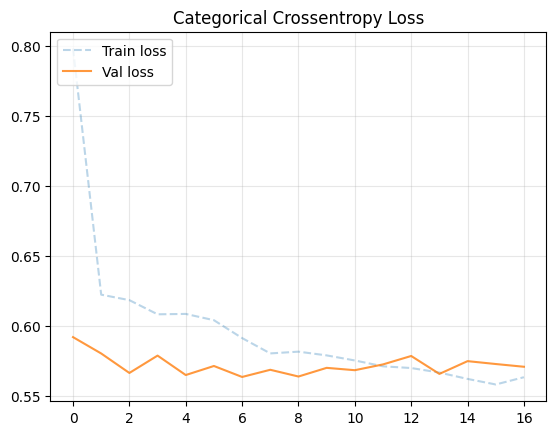

In [12]:
# Plot loss curves
plt.style.use('default')
plt.plot(history['loss'], label='Train loss', alpha=0.3, linestyle='--')
plt.plot(history['val_loss'], label='Val loss', alpha=0.8)
plt.title('Categorical Crossentropy Loss')
plt.legend(loc='upper left')
plt.grid(alpha=0.3)

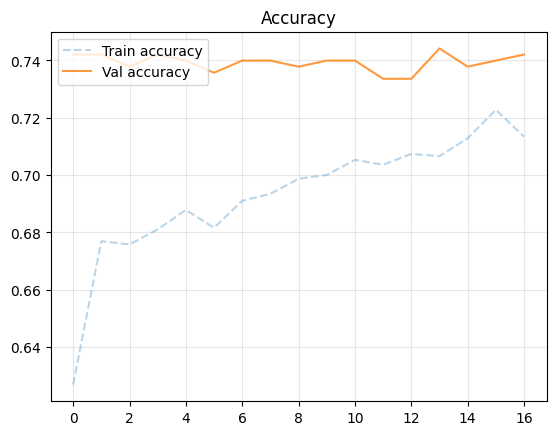

In [13]:
# Plot accuracy curves
plt.style.use('default')
plt.plot(history['accuracy'], label='Train accuracy', alpha=0.3, linestyle='--')
plt.plot(history['val_accuracy'], label='Val accuracy', alpha=0.8)
plt.title('Accuracy')
plt.legend(loc='upper left')
plt.grid(alpha=0.3)

8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step 
Accuracy:  0.74
Precision:  0.0
Recall:  0.0
F1 score:  0.0


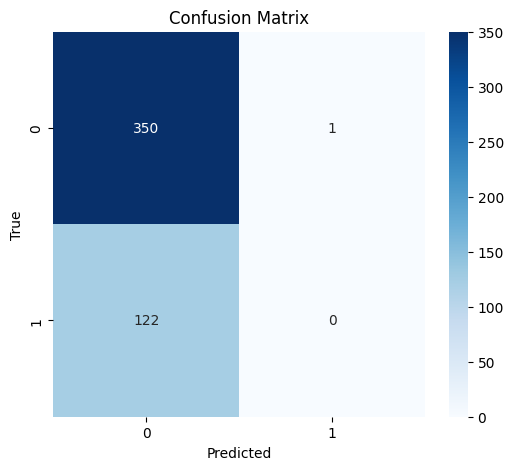

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Collect true labels
y_true = []
for _, labels in val_generator:
    y_true.extend(labels)
    if len(y_true) >= val_generator.samples:  # Stop when all samples are processed
        break

y_true = np.array(y_true)

# If class_mode is 'binary', labels might have an extra dimension (shape: (batch_size, 1)), so we flatten
if val_generator.class_mode == 'binary':
    y_true = y_true.flatten()

# Predict on validation data
y_pred = model.predict(val_generator)

# Convert probabilities to class labels (0 or 1)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

# Print accuracy
print("Accuracy: ", round(accuracy_score(y_true, y_pred_classes), 2))
print("Precision: ", round(precision_score(y_true, y_pred_classes), 2))
print("Recall: ", round(recall_score(y_true, y_pred_classes), 2))
print("F1 score: ", round(f1_score(y_true, y_pred_classes), 2))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [15]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import cv2  # For heatmap overlay

def grad_cam_2d(model, img, layer_name, class_idx=None):
    """
    Generate a Grad-CAM heatmap for a 2D input image.

    :param model: Trained CNN model
    :param img: Input 2D image (shape: (height, width, channels))
    :param layer_name: Name of the convolutional layer to inspect
    :param class_idx: Class index for which to compute Grad-CAM (default: predicted class)
    :return: Heatmap of activations
    """
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Get the specified convolutional layer
    conv_layer = model.get_layer(layer_name)

    # Create a model that maps the input to the activations of the chosen layer & predictions
    grad_model = Model(inputs=model.input, outputs=[conv_layer.output, model.output])

    # Compute gradients
    with tf.GradientTape() as tape:
        conv_output, preds = grad_model(img)
        if class_idx is None:
            class_idx = np.argmax(preds)  # Default to predicted class
        loss = preds[:, class_idx]

    # Compute gradients of the target class w.r.t. the convolutional layer output
    grads = tape.gradient(loss, conv_output)

    # Compute the importance of each channel via global average pooling
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Pool across spatial dimensions

    # Multiply feature maps by importance weights
    conv_output = conv_output[0].numpy()  # Convert to NumPy array
    # Remove batch dimension
    for i in range(pooled_grads.shape[-1]):  # Iterate over channels
        conv_output[:, :, i] *= pooled_grads[i]

    # Compute mean across channels
    heatmap = np.mean(conv_output, axis=-1)

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0)  # ReLU to remove negatives
    heatmap /= np.max(heatmap)  # Normalize to [0,1]

    return heatmap


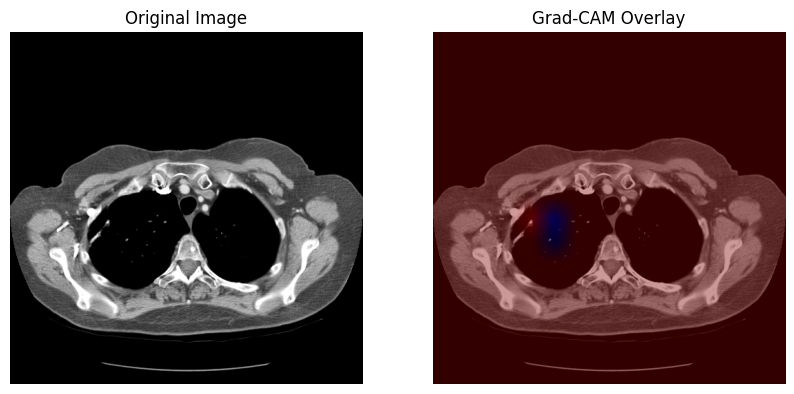

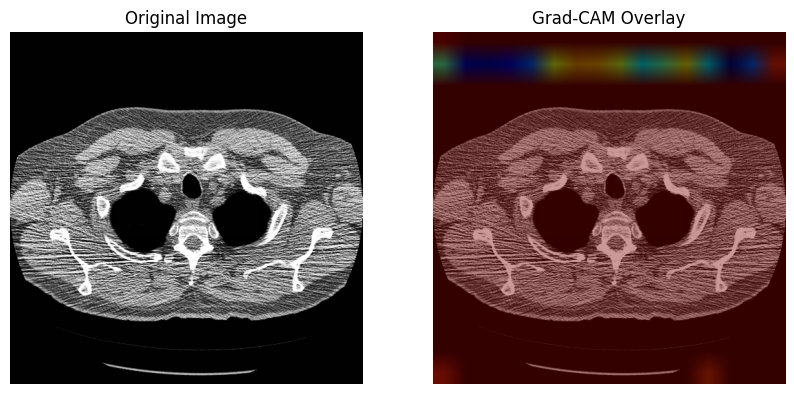

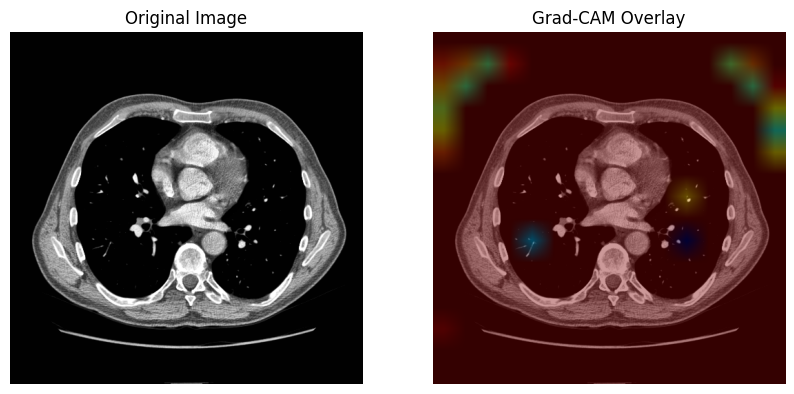

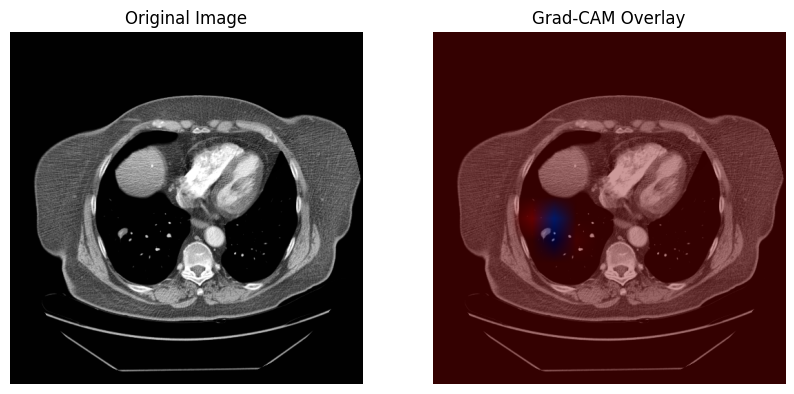

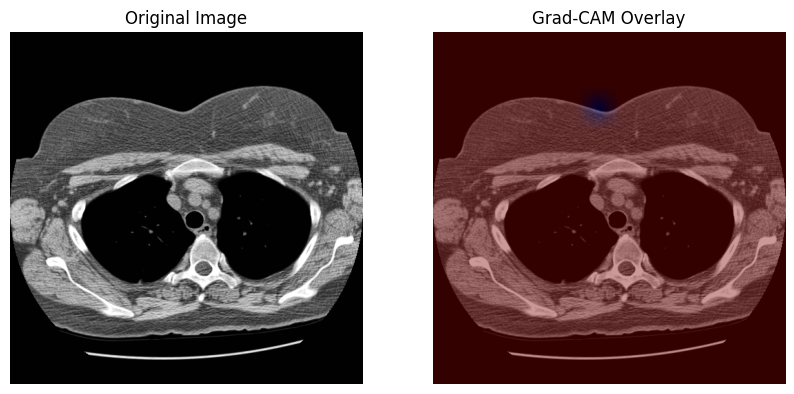

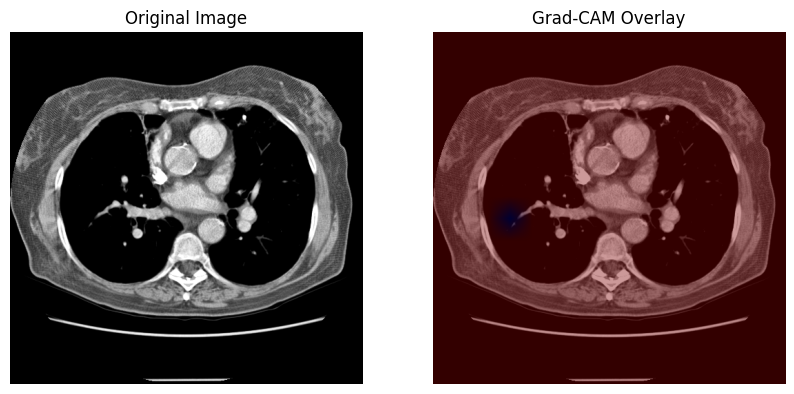

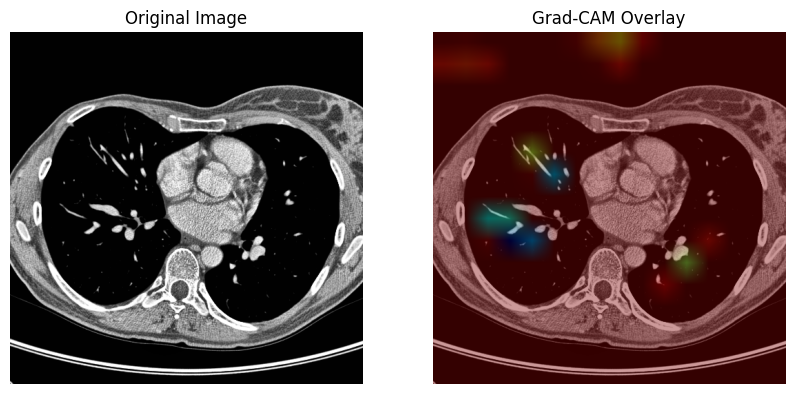

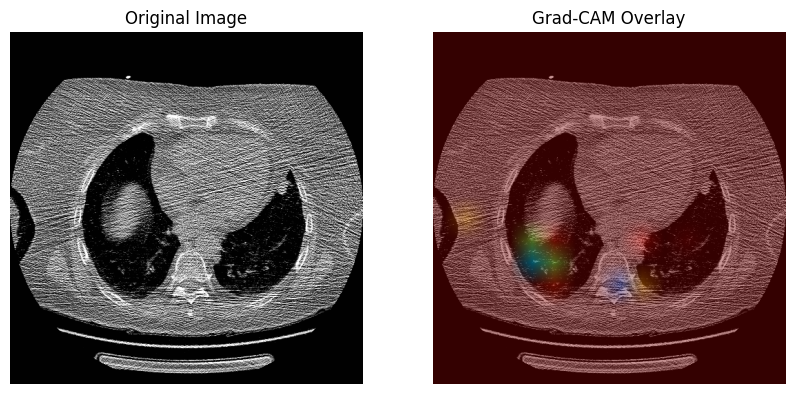

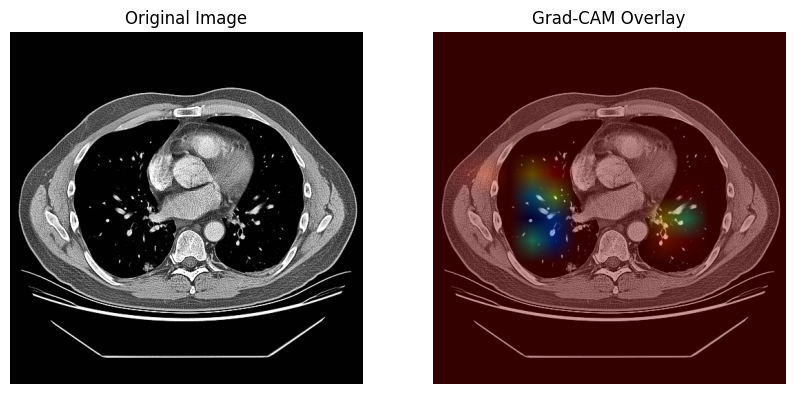

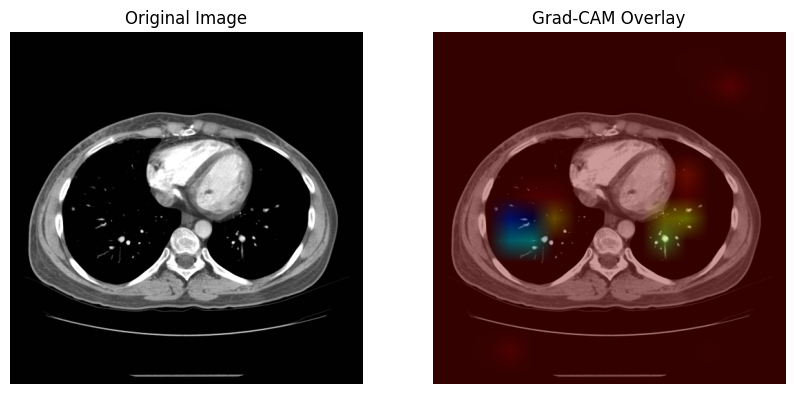

<ipython-input-15-e19e79276737>:50: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)  # Normalize to [0,1]
<ipython-input-16-fd3ca15092e4>:13: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)


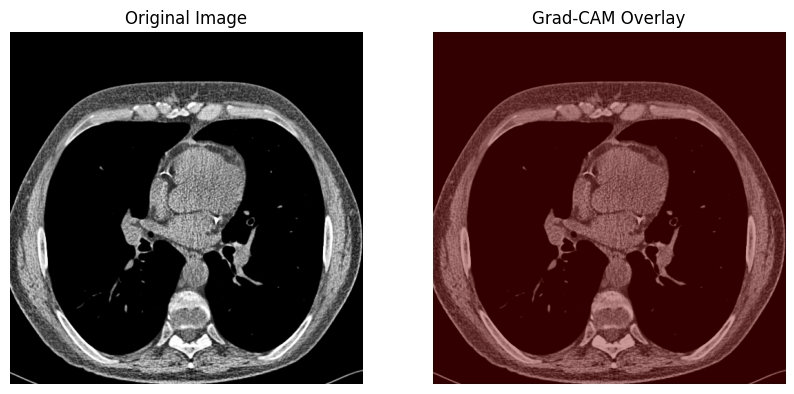

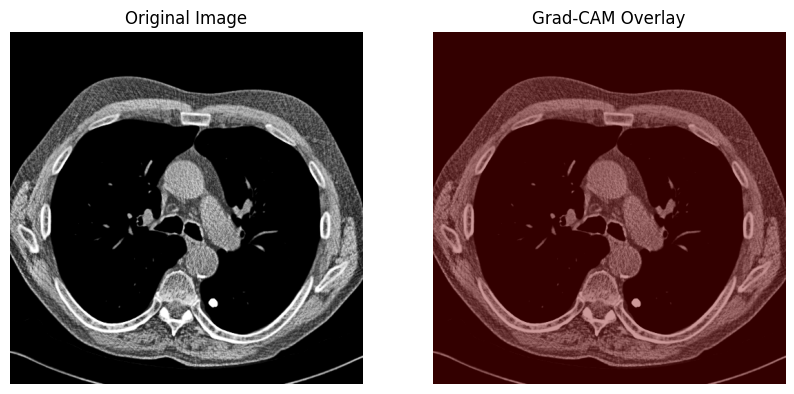

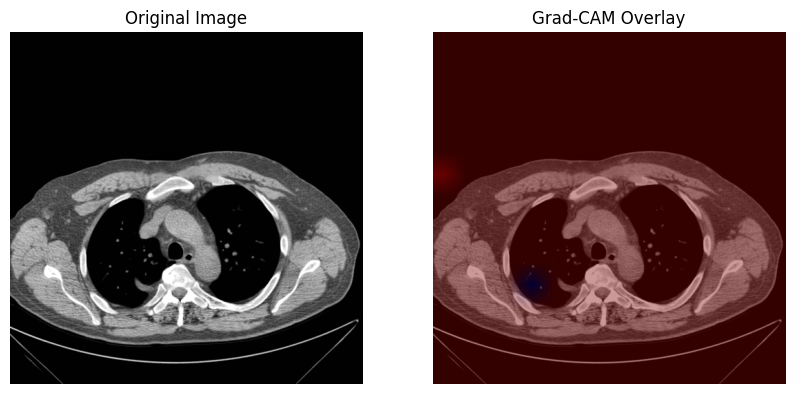

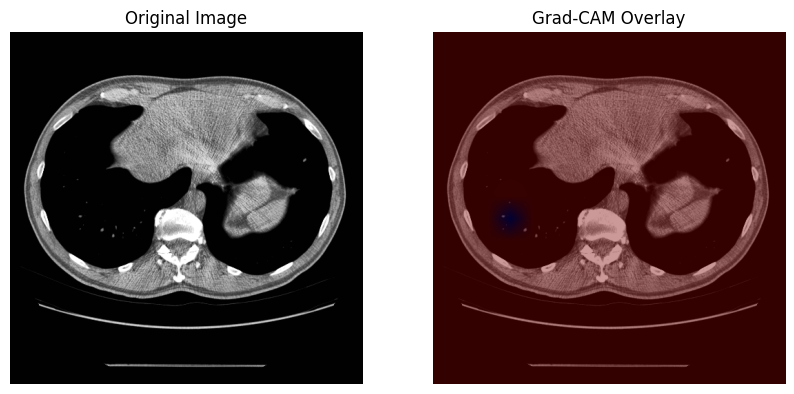

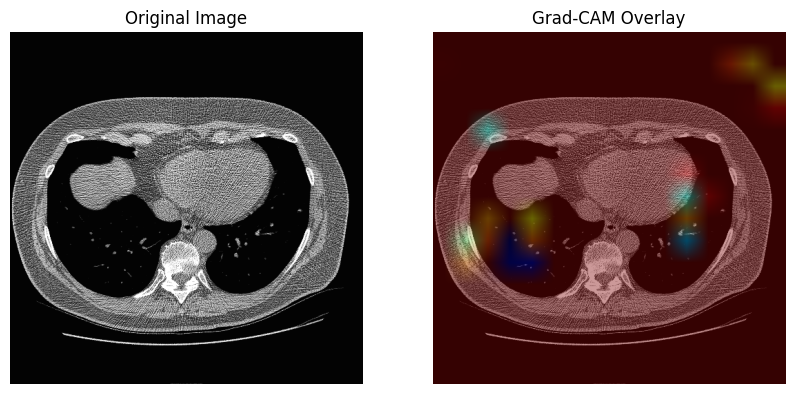

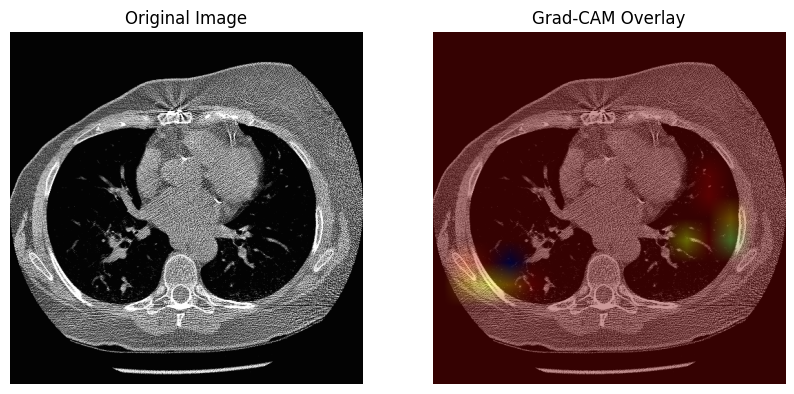

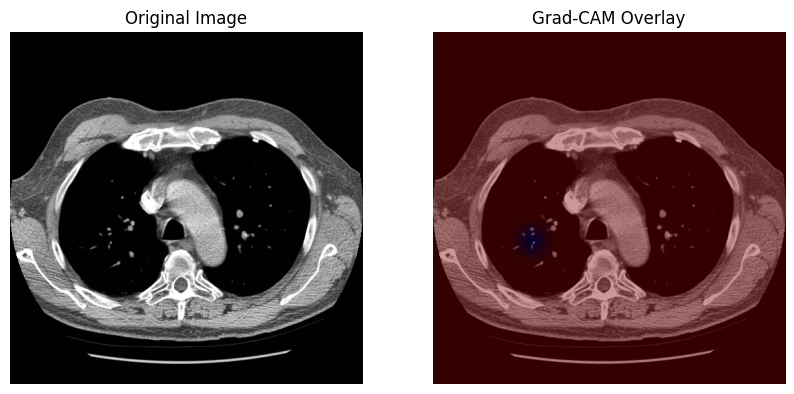

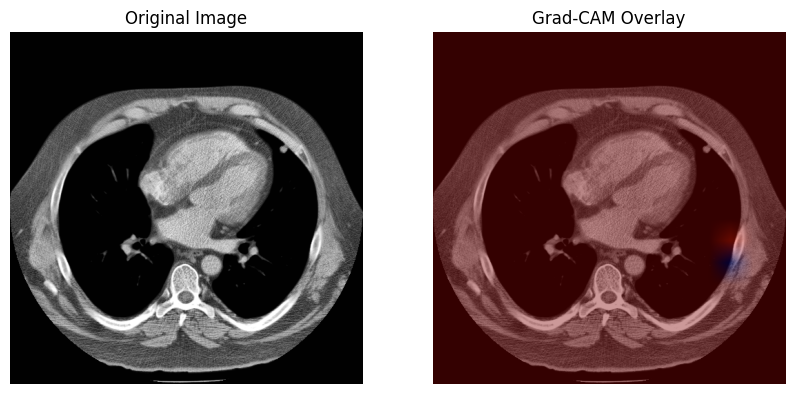

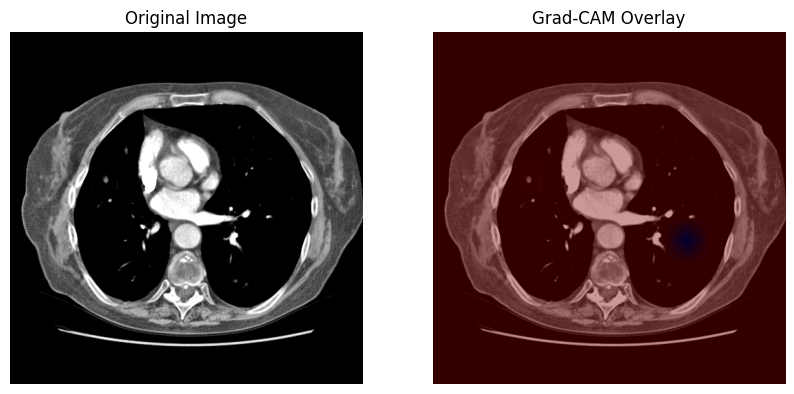

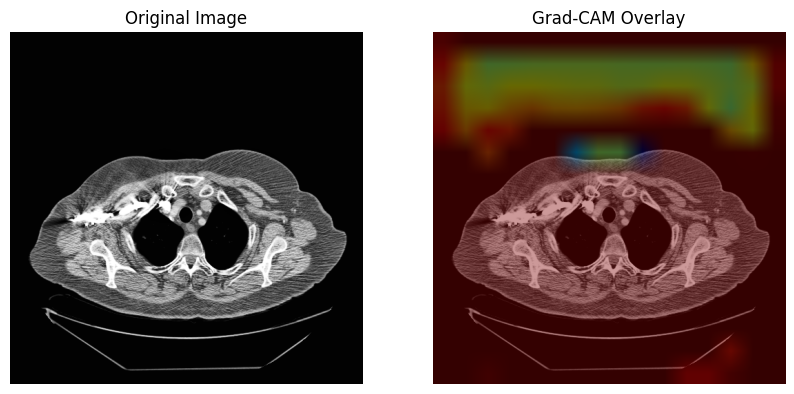

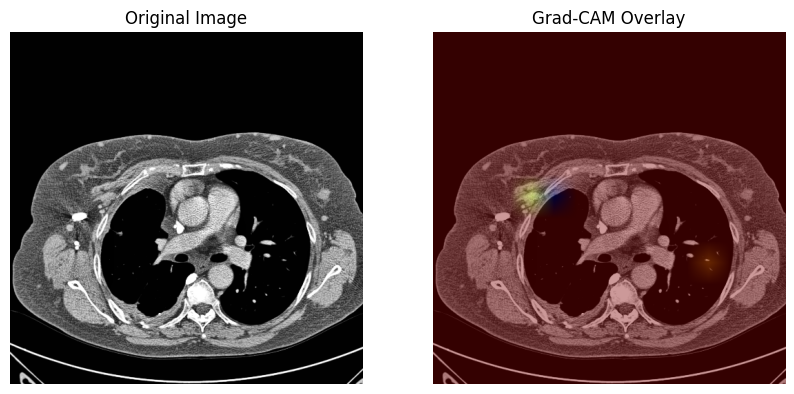

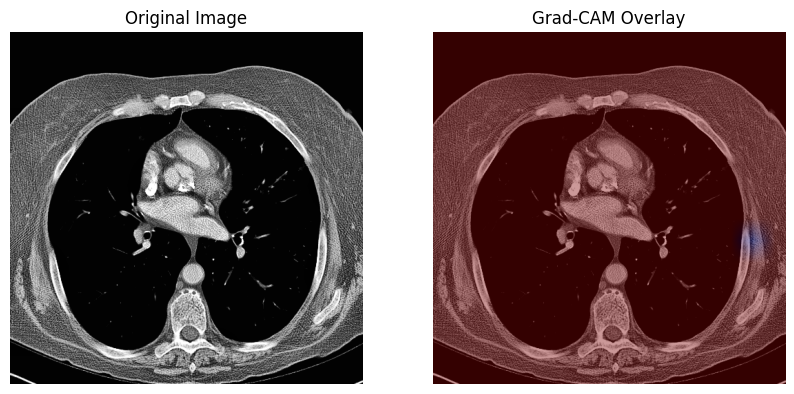

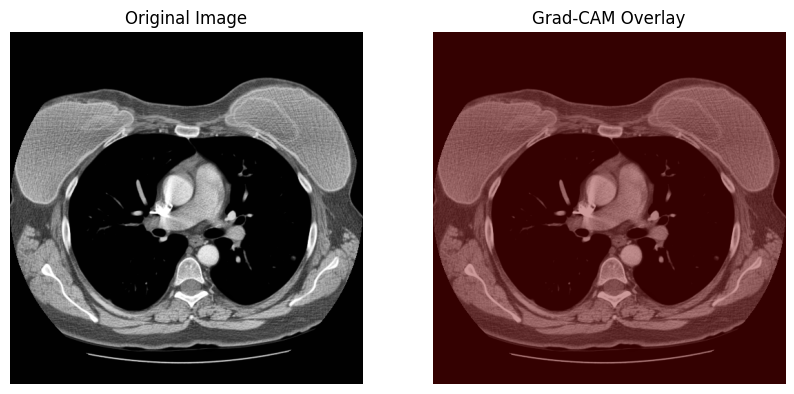

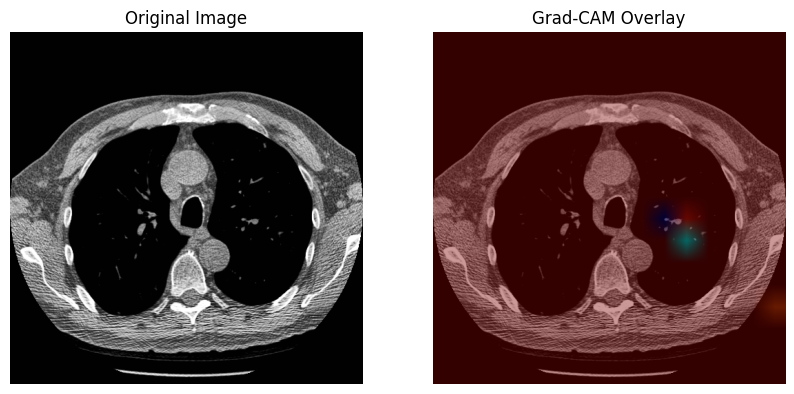

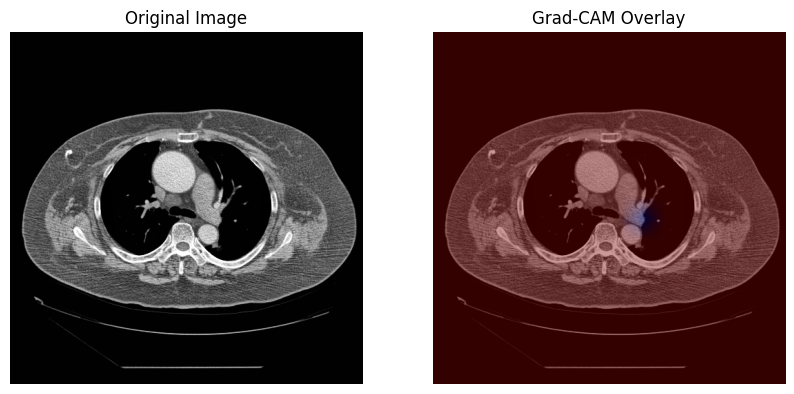

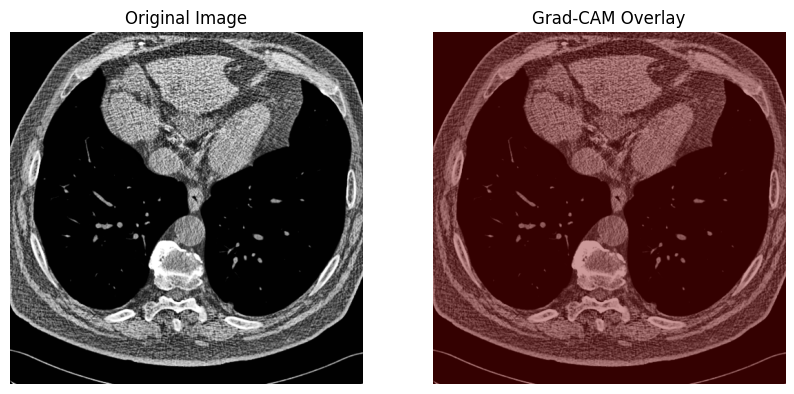

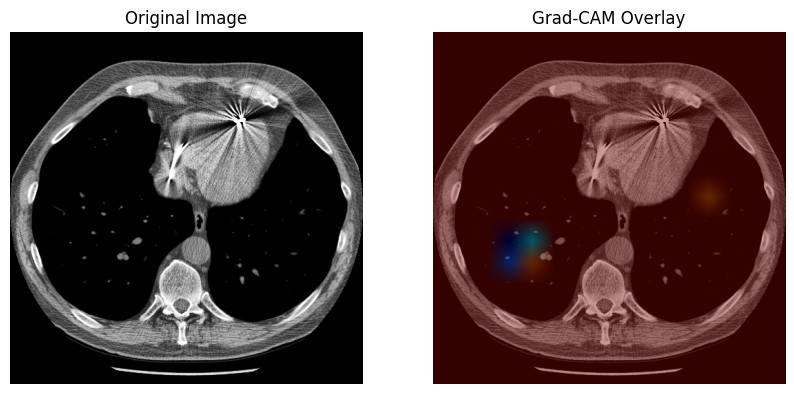

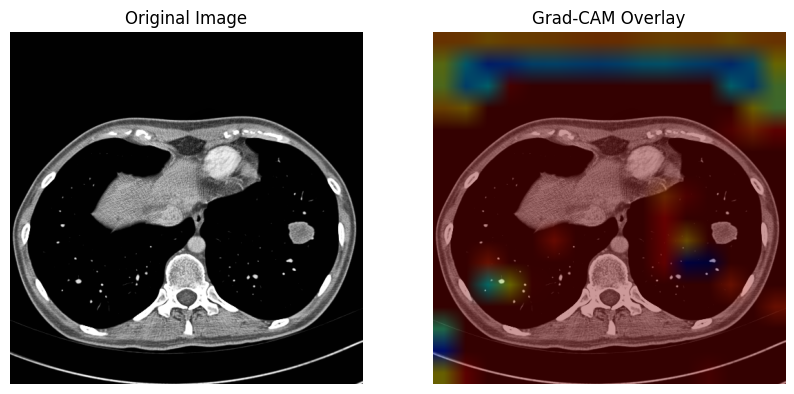

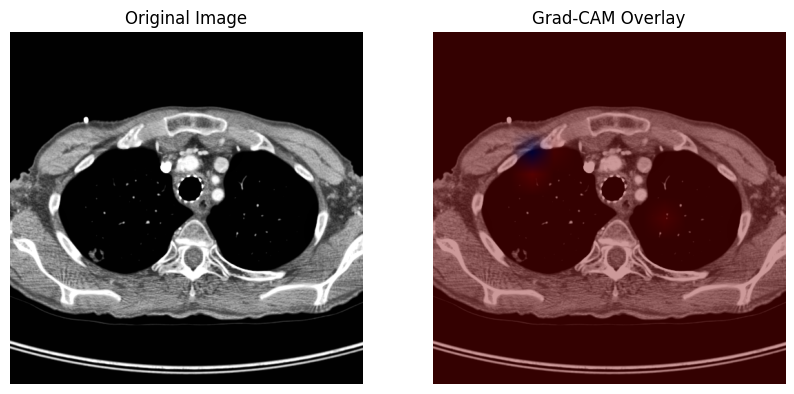

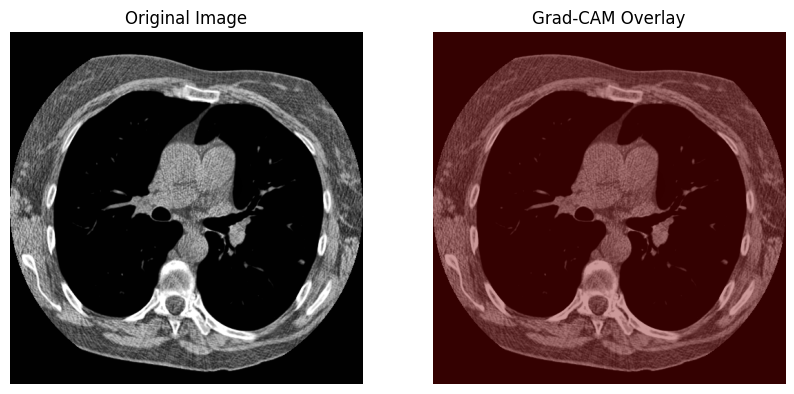

In [16]:
for i in range(30):
    # Load a sample 2D image (shape: (height, width, channels))
    sample_img = next(val_generator)[0][i]
    
    # Choose the last convolutional layer
    conv_layer_name = 'conv2d'  # Replace with actual layer name
    
    # Compute Grad-CAM heatmap
    heatmap = grad_cam_2d(model, sample_img, conv_layer_name)
    
    # Ensure heatmap is 3-channel
    if len(heatmap.shape) == 2:  # If heatmap is grayscale (H, W), convert to (H, W, 3)
        heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    
    # Convert both images to uint8
    sample_img = np.uint8(255 * (sample_img - np.min(sample_img)) / (np.max(sample_img) - np.min(sample_img)))
    heatmap = np.uint8(heatmap)
    
    # Resize heatmap to match sample_img shape
    heatmap = cv2.resize(heatmap, (sample_img.shape[1], sample_img.shape[0]))
    
    # Blend images
    overlay = cv2.addWeighted(sample_img, 0.6, heatmap, 0.4, 0)
    
    # Show the result
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(sample_img)
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title("Grad-CAM Overlay")
    plt.axis("off")
    
    plt.show()
